In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['masks', 'test', 'train']


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

import glob, shutil,os,random,sys
from PIL import Image

from tensorflow import reduce_sum
from keras.backend import pow
from keras import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten,LeakyReLU
from keras.losses import binary_crossentropy
from keras.callbacks import  ModelCheckpoint,Callback,LearningRateScheduler
import keras.callbacks as callbacks
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import cv2

from tqdm import tqdm_notebook

seed = 10
np.random.seed(seed)
random.seed(seed)
tf.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
!pip install -U efficientnet==0.0.4

Using TensorFlow backend.


  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14289 sha256=fbd56158770af9859ed40cd858f485c58b5d5cec69302a1558f45f7982391149
  Stored in directory: /tmp/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


Hyper parameters

In [3]:
h,w,batch_size = 256,256,16
image_size = 256
epochs = 5
path_for_mask = "../input/masks/"
path_for_train = "../input/train/"
path_for_test = "../input/test/"
U_net_model = False
U_net_PP_model = False

Mask Functions

In [4]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

Extract Image Data

In [5]:
all_mask_fn = glob.glob(path_for_mask + "*")
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255)
    
mask_df.reset_index(inplace=True)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

all_train_fn = glob.glob(path_for_train + '*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)#generate an array from 0 to len(total samples)
train_fn,val_fn = train_test_split(all_train_fn,stratify=mask_df.labels,test_size=0.1,random_state=10)

masks_train_fn = [fn.replace('./train','./masks') for fn in train_fn]    
masks_val_fn = [fn.replace('./train','./masks') for fn in val_fn]

print('No. of train files %d and labels %d'%(len(train_fn),len(masks_train_fn)))
print('No. of val files %d and lable %d'%(len(val_fn),len(masks_val_fn)))

No. of train files 9607 and labels 9607
No. of val files 1068 and lable 1068


Generate Train, validation set

In [6]:
train_mask = []
val_mask = []
for i in train_fn:
    img_label = i.split("/")[-1]
    mask_path = path_for_mask + img_label
    if(mask_path in all_mask_fn):
        train_mask.append(mask_path)
    else:
        "Train mask not found"
        
for i in val_fn:
    img_label = i.split("/")[-1]
    mask_path = path_for_mask + img_label
    if(mask_path in all_mask_fn):
        val_mask.append(mask_path)
    else:
        "Valid mask not found"

Generate IOU(as model accrucy)

In [7]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        dice = 2 * iou
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        #iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += dice
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

Image Augmentation Methods

In [8]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(156, 256), height=h, width=w,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

Define Data Generator

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_fn,train_mask_path=train_mask,
                 augmentations=None, batch_size=batch_size,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        
        self.train_im_path = train_im_path#list of training image
        self.train_mask_path = train_mask_path#list of trainig mask

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.train_im_path) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_path))]

        # Find list of IDs
        list_IDs_im = [self.train_im_path[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_path))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            imgNum = im_path.split("train/")[1]
            mask = np.array(Image.open(path_for_mask+imgNum))
      
            if len(im.shape)==2:
                im = np.expand_dims(im,axis=2)
            X[i,] = im

            mask = np.expand_dims(mask,axis=2)
            y[i,] = mask
            y[y>0] = 255
        return np.uint8(X),np.uint8(y)

Some Result with augmentation

Text(0.5, 0.98, 'Chest X-rays(No Augm), Red: Pneumothorax.')

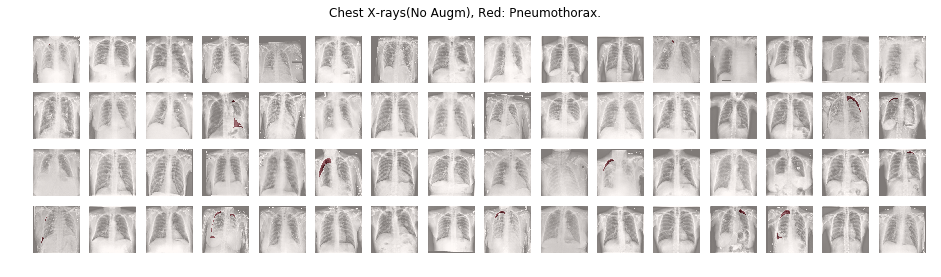

In [10]:
a = DataGenerator(batch_size=64,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays(No Augm), Red: Pneumothorax.")

Some Results with augmentation

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

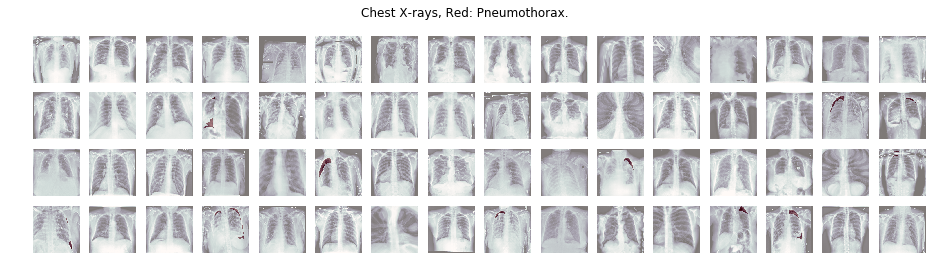

In [11]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

Loss function

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

Learning rate scheduler ( using cosine annealing)

In [13]:
class CallBackObjects:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        self.iteration = 0
        self.learningRate = []

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_my_iou_metric', mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list
    
    def on_train_batch_begin(self,nb_epochs):
        pass
    
    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

Implemening SWA gives a better result

In [14]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

Unet

In [15]:
def down_block(x,filters,kernel_size=(3,3),padding='same',strides=1):
    c=keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation='relu')(x)
    c=keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation='relu')(c)
    p=keras.layers.MaxPool2D((2,2),(2,2))(c)
    return c,p
def up_block(x,skip,filters,kernel_size=(3,3),padding='same',strides=1):
    us=keras.layers.UpSampling2D((2,2))(x)
    concat=keras.layers.concatenate([us,skip],axis=3)
    c=keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation='relu')(concat)
    c=keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation='relu')(c)
    return c
def bottleNeck(x,filters,kernel_size=(3,3),padding='same',strides=1):
    c=keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation='relu')(x)
    c=keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation='relu')(c)
    return c
def unet():
    f = [64,128,256,512,1024]#feature maps, number of filters
    inputs=keras.layers.Input((image_size,image_size,3))#input to the model
    p0 = inputs
    c1,p1 = down_block(p0,f[0])#1->64
    c2,p2 = down_block(p1,f[1])#64->128
    c3,p3 = down_block(p2,f[2])#128->256
    c4,p4 = down_block(p3,f[3])#256->512
    drop1 = keras.layers.Dropout(0.5)(p4)
    
    bn = bottleNeck(drop1,f[4])#512->1024
    drop2 = keras.layers.Dropout(0.5)(bn)

    u1 = up_block(drop2,c4,f[3])#1024->512
    u2 = up_block(u1,c3,f[2])#512->256
    u3 = up_block(u2,c2,f[1])#256->128
    u4 = up_block(u3,c1,f[0])#128->64
    
    outputs_up = keras.layers.Conv2D(2,(3,3),padding="same",activation="relu")(u4)#64->2
    outputs = keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(outputs_up)#2->1
    model = keras.models.Model(inputs,outputs)
    return model

U-net ++ with efficientNet Encoder

In [16]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = keras.layers.BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = keras.layers.BatchNormalization()(x)
    blockInput = keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = keras.layers.Add()([x, blockInput])
    return x

In [17]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = keras.layers.Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = keras.layers.concatenate([deconv4, conv4])
    uconv4 = keras.layers.Dropout(dropout_rate)(uconv4) 
    
    uconv4 = keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = keras.layers.concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = keras.layers.concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = keras.layers.Dropout(0.1)(uconv2)
    uconv2 = keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = keras.layers.concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = keras.layers.Dropout(0.1)(uconv1)
    uconv1 = keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = keras.layers.Dropout(0.1)(uconv0)
    uconv0 = keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model



In [18]:
K.clear_session()


Uncomment code below to using U-net model

In [19]:
# U_net_model = unet()

Uncomment code below to using U-net++ model

In [20]:
U_net_PP_model = UEfficientNet(input_shape=(image_size,image_size,3),dropout_rate=0.5)

71720960/71719528 [==============================] - 1s 0us/step


In [21]:
try:
    if U_net_model:
        model = U_net_model
    elif U_net_PP_model:
        model = U_net_PP_model
    model.compile(loss=bce_dice_loss,optimizer="adam", metrics=[my_iou_metric])
    #model.summary()
    snapshot = CallBackObjects(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
    if epochs < 5:
        swa = SWA('./keras_swa.model',1)
    elif 5<=epochs and epochs<= 10:
        swa = SWA('./keras_swa.model',(epochs-3))
    elif epochs <= 20:
        swa = SWA('./keras_swa.model',(epochs-5))
    elif epochs > 20:
        swa = SWA('./keras_swa.model',(epochs-10))
except:
    print("Error: A model need to be selected")
training_generator = DataGenerator(batch_size=16,augmentations=AUGMENTATIONS_TRAIN,img_size=image_size)
validation_generator = DataGenerator(batch_size=16,train_im_path = val_fn ,
                                     train_mask_path=val_mask,augmentations=AUGMENTATIONS_TEST,
                                     img_size=image_size)

history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=epochs,verbose=1,
                            callbacks=snapshot.get_callbacks())






Stochastic weight averaging selected for last 3 epochs.
Epoch 1/5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater


600/600 [==============================] - 373s 622ms/step - loss: 1.2341 - my_iou_metric: 0.0165 - val_loss: 1.0002 - val_my_iou_metric: 0.4776

Epoch 00001: val_my_iou_metric improved from -inf to 0.47764, saving model to ./keras.model
Epoch 2/5
600/600 [==============================] - 332s 553ms/step - loss: 1.0229 - my_iou_metric: 0.0577 - val_loss: 0.8478 - val_my_iou_metric: 0.5362

Epoch 00002: val_my_iou_metric improved from 0.47764 to 0.53616, saving model to ./keras.model
Epoch 3/5
600/600 [==============================] - 331s 552ms/step - loss: 0.9495 - my_iou_metric: 0.0791 - val_loss: 0.7470 - val_my_iou_metric: 0.7903

Epoch 00003: val_my_iou_metric improved from 0.53616 to 0.79026, saving model to ./keras.model
Epoch 4/5
600/600 [==============================] - 331s 552ms/step - loss: 0.8395 - my_iou_metric: 0.1499 - val_loss: 0.6701 - val_my_iou_metric: 0.7949

Epoch 00004: val_my_iou_metric improved from 0.79026 to 0.79488, saving model to ./keras.model
Epoch 5/5

Plots of Learning curves and change of learning rate

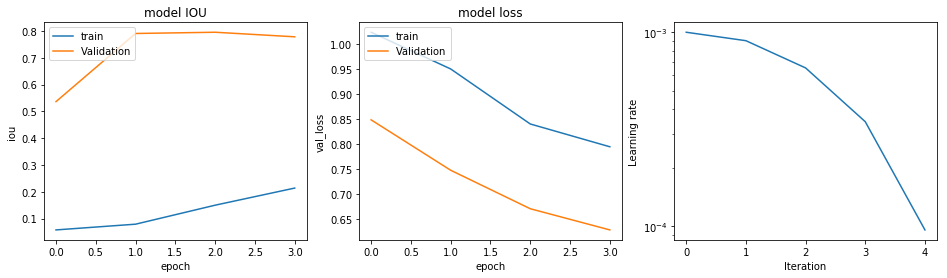

In [26]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,3,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
gc.collect()

plt.subplot(1,3,3)
#plt.plot(list(np.arange(epochs)))
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()

Using trained model for prediction

In [27]:
test_fn = glob.glob(path_for_test + '*')
x_test = [cv2.resize(np.array(Image.open(fn)),(image_size,image_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
preds_test = model.predict(x_test,batch_size=batch_size)

Some prediction results

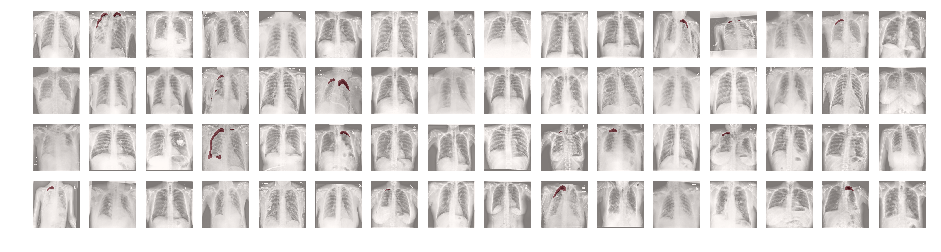

In [28]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img.squeeze(), cmap="Greys")
    ax.imshow(np.array(np.round(pred > 0.5), dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

Generating a submission csv file

In [30]:
rles = []

for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > 0.5
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))


ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()
sub_df.to_csv('submission.csv', index=False)
sub_df.tail(10)

,ImageId,EncodedPixels
1367,1.2.276.0.7230010.3.1.4.8323329.6234.151787519...,-1
1368,1.2.276.0.7230010.3.1.4.8323329.7046.151787520...,-1
1369,1.2.276.0.7230010.3.1.4.8323329.5899.151787519...,-1
1370,1.2.276.0.7230010.3.1.4.8323329.6462.151787519...,-1
1371,1.2.276.0.7230010.3.1.4.8323329.6351.151787519...,-1
1372,1.2.276.0.7230010.3.1.4.8323329.6407.151787519...,476344 5 1013 18 1003 26 995 32 990 37 986 39 ...
1373,1.2.276.0.7230010.3.1.4.8323329.6329.151787519...,-1
1374,1.2.276.0.7230010.3.1.4.8323329.6137.151787519...,259262 1 6 2 1013 4 4 3 1012 5 1016 9 1012 13 ...
1375,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,274733 10 1012 13 1009 15 1008 16 1005 19 1003...
1376,1.2.276.0.7230010.3.1.4.8323329.6586.151787519...,576643 14 1006 23 996 30 992 34 989 35 986 39 ...
